<a href="https://colab.research.google.com/github/Mohammad-H-Zahrawi/machine_Learning_fundamentals/blob/master/deep_learning/4_Convolutional_Neural_Networks_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. Convolutional Neural Networks and Computer Vision with TensorFlow



### checking GPU

In [ ]:
!nvidia-smi

Fri Oct  8 10:30:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.6535486190000483
GPU (s):
0.04462640300005205
GPU speedup over CPU: 81x


 Note: In deep learning, many different kinds of model architectures can be used for different problems. For example, you could use a convolutional neural network for making predictions on image data and/or text data. However, in practice some architectures typically work better than others.

## What we're going to cover

Specifically, we're going to go through the follow with TensorFlow:

- Getting a dataset to work with
- Architecture of a convolutional neural network
- A quick end-to-end example (what we're working towards)
- Steps in modelling for binary image classification with CNNs
  - Becoming one with the data
  - Preparing data for modelling
  - Creating a CNN model (starting with a baseline)
  - Fitting a model (getting it to find patterns in our data)
  - Evaluating a model
  - Improving a model
  - Making a prediction with a trained model
- Steps in modelling for multi-class image classification with CNNs
 - Same as above (but this time with a different dataset)

## Get the data
The images we're going to work with are from the [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), a collection of 101 different categories of 101,000 (1000 images per category) real-world images of food dishes.

> 🔑 **Note:** To prepare the data we're using, preprocessing steps such as, moving the images into different subset folders, have been done. To see these preprocessing steps check out [the preprocessing notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).

We'll download the `pizza_steak` subset .zip file and unzip it.

In [ ]:
import zipfile

  # Download zip file of pizza_steak images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip 

zip_ref = zipfile.ZipFile('pizza_steak.zip','r')
zip_ref.extractall()
zip_ref.close()

--2021-10-08 09:34:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109579078 (105M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.50M  44.8MB/s    in 2.3s    

2021-10-08 09:35:02 (44.8 MB/s) - ‘pizza_steak.zip’ saved [109579078/109579078]



## Inspect the data (become one with it)
A very crucial step at the beginning of any machine learning project is becoming one with the data. This usually means plenty of visualizing and folder scanning to understand the data you're working with.

In [ ]:
!ls

__MACOSX  pizza_steak  pizza_steak.zip	sample_data


In [ ]:
!ls pizza_steak/

test  train


In [ ]:
!ls pizza_steak/train/

pizza  steak


In [ ]:
!ls pizza_steak/test/steak/

100274.jpg   1653815.jpg  2307638.jpg  2944161.jpg  3622237.jpg  638678.jpg
1012080.jpg  1655387.jpg  2308682.jpg  2945937.jpg  365725.jpg	 640024.jpg
1016217.jpg  1662212.jpg  2315011.jpg  296375.jpg   3662612.jpg  647683.jpg
1064847.jpg  168551.jpg   2339231.jpg  2981911.jpg  367422.jpg	 653303.jpg
1082384.jpg  1687010.jpg  2353677.jpg  2984679.jpg  3681340.jpg  66183.jpg
108310.jpg   1718949.jpg  2365038.jpg  2989645.jpg  3753767.jpg  66207.jpg
1094883.jpg  1778186.jpg  2372048.jpg  3013185.jpg  3757027.jpg  66858.jpg
1107549.jpg  1792128.jpg  2382600.jpg  3013404.jpg  378397.jpg	 670345.jpg
1118585.jpg  1794566.jpg  2416973.jpg  3029602.jpg  3786535.jpg  673127.jpg
1163050.jpg  1848046.jpg  2475366.jpg  3048920.jpg  3835895.jpg  690177.jpg
1166047.jpg  1848936.jpg  2484823.jpg  3060047.jpg  3842125.jpg  690477.jpg
1190808.jpg  1868005.jpg  2510026.jpg  3062369.jpg  3873283.jpg  697562.jpg
1194662.jpg  1872368.jpg  2512387.jpg  3063435.jpg  3873655.jpg  7056.jpg
1206166.jpg  1874088

In [ ]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath,dirnames,filenames in os.walk("pizza_steak"):
  print('there are ',len(dirnames),'directories and ',len(filenames),'images in',dirpath)

there are  2 directories and  1 images in pizza_steak
there are  2 directories and  1 images in pizza_steak/test
there are  0 directories and  250 images in pizza_steak/test/steak
there are  0 directories and  250 images in pizza_steak/test/pizza
there are  2 directories and  1 images in pizza_steak/train
there are  0 directories and  750 images in pizza_steak/train/steak
there are  0 directories and  750 images in pizza_steak/train/pizza


In [ ]:
num_steak_images_train = len(os.listdir('/content/pizza_steak/train/steak/'))
num_steak_images_train

750

In [ ]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np

data_dir = pathlib.Path('pizza_steak/train/')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names[1:])

['pizza' 'steak']


🤔 Note: Whenever you're working with data, it's always good to visualize it as much as possible. Treat your first couple of steps of a project as becoming one with the data. Visualize, visualize, visualize.

In [ ]:
# view an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir , target_class):
    # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class
  
  # get a random image path
  random_image = random.sample(os.listdir(target_folder),1)
  
  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"image shape :{img.shape}")

image shape :(512, 512, 3)


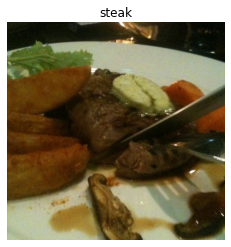

In [ ]:
# View a random image from the training dataset
img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="steak")

In [ ]:
img_2 = mpimg.imread('/content/pizza_steak/test/pizza/1060407.jpg')
img_2.shape

(512, 512, 3)

In [ ]:
img_2

array([[[127, 100,  57],
        [138, 111,  68],
        [133, 106,  63],
        ...,
        [ 60,  43,  23],
        [ 64,  47,  27],
        [ 67,  51,  28]],

       [[134, 107,  64],
        [141, 114,  71],
        [134, 107,  64],
        ...,
        [ 58,  41,  21],
        [ 58,  42,  19],
        [ 59,  43,  20]],

       [[139, 112,  69],
        [142, 115,  72],
        [134, 107,  62],
        ...,
        [ 65,  49,  26],
        [ 63,  47,  24],
        [ 61,  45,  22]],

       ...,

       [[ 48,  40,  27],
        [ 51,  43,  30],
        [ 55,  47,  34],
        ...,
        [100,  73,  30],
        [101,  74,  31],
        [102,  75,  32]],

       [[ 45,  37,  24],
        [ 48,  40,  27],
        [ 51,  43,  30],
        ...,
        [104,  77,  34],
        [104,  77,  34],
        [104,  77,  34]],

       [[ 47,  39,  26],
        [ 49,  41,  28],
        [ 51,  43,  30],
        ...,
        [109,  82,  39],
        [110,  83,  40],
        [110,  83,  40]]

Looking at the image shape more closely, you'll see it's in the form (Width, Height, Colour Channels).

You'll notice all of the values in the img array are between 0 and 255. This is because that's the possible range for red, green and blue values. For example, a pixel with a value red=0, green=0, blue=255 will look very blue.

In [ ]:
# Get all the pixel values between 0 & 1
img_2/255.0

array([[[0.49803922, 0.39215686, 0.22352941],
        [0.54117647, 0.43529412, 0.26666667],
        [0.52156863, 0.41568627, 0.24705882],
        ...,
        [0.23529412, 0.16862745, 0.09019608],
        [0.25098039, 0.18431373, 0.10588235],
        [0.2627451 , 0.2       , 0.10980392]],

       [[0.5254902 , 0.41960784, 0.25098039],
        [0.55294118, 0.44705882, 0.27843137],
        [0.5254902 , 0.41960784, 0.25098039],
        ...,
        [0.22745098, 0.16078431, 0.08235294],
        [0.22745098, 0.16470588, 0.0745098 ],
        [0.23137255, 0.16862745, 0.07843137]],

       [[0.54509804, 0.43921569, 0.27058824],
        [0.55686275, 0.45098039, 0.28235294],
        [0.5254902 , 0.41960784, 0.24313725],
        ...,
        [0.25490196, 0.19215686, 0.10196078],
        [0.24705882, 0.18431373, 0.09411765],
        [0.23921569, 0.17647059, 0.08627451]],

       ...,

       [[0.18823529, 0.15686275, 0.10588235],
        [0.2       , 0.16862745, 0.11764706],
        [0.21568627, 0

## A (typical) architecture of a convolutional neural network


Components of a convolutional neural network:

| **Hyperparameter/Layer type** | **What does it do?** | **Typical values** |
| ----- | ----- | ----- |
| Input image(s) | Target images you'd like to discover patterns in| Whatever you can take a photo (or video) of |
| Input layer | Takes in target images and preprocesses them for further layers | `input_shape = [batch_size, image_height, image_width, color_channels]` |
| Convolution layer | Extracts/learns the most important features from target images | Multiple, can create with [`tf.keras.layers.ConvXD`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) (X can be multiple values) |
| Hidden activation | Adds non-linearity to learned features (non-straight lines) | Usually ReLU ([`tf.keras.activations.relu`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu)) |
| Pooling layer | Reduces the dimensionality of learned image features | Average ([`tf.keras.layers.AvgPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D)) or Max ([`tf.keras.layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)) |
| Fully connected layer | Further refines learned features from convolution layers | [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) |
| Output layer | Takes learned features and outputs them in shape of target labels | `output_shape = [number_of_classes]` (e.g. 3 for pizza, steak or sushi)|
| Output activation | Adds non-linearities to output layer | [`tf.keras.activations.sigmoid`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid) (binary classification) or [`tf.keras.activations.softmax`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) |

How they stack together:

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-simple-convnet.png)
*A simple example of how you might stack together the above layers into a convolutional neural network. Note the convolutional and pooling layers can often be arranged and rearranged into many different formations.*

### An end-to-end example

🔑 Note: A baseline is a score or evaluation metric you want to try and beat. Usually you'll start with a simple model, create a baseline and try to beat it by increasing the complexity of the model. A really fun way to learn machine learning is to find some kind of modelling paper with a published result and try to beat it

> 📖 **Resource:** The architecture we're using below is a scaled-down version of [VGG-16](https://arxiv.org/abs/1505.06798), a convolutional neural network which came 2nd in the 2014 [ImageNet classification competition](http://image-net.org/).

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1/255.)
valid_datagen = ImageDataGenerator(rescale=1/255.)

# Setup the train and test directories
train_dir = "pizza_steak/train"
test_dir = "pizza_steak/test"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,batch_size=32,target_size=(224,224),class_mode='binary',seed=42)
valid_data = train_datagen.flow_from_directory(test_dir,batch_size=32,target_size=(224,224),class_mode='binary',seed=42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
                tf.keras.layers.Conv2D(filters=10,kernel_size=3,activation='relu',input_shape=(224,224,3)),
                tf.keras.layers.Conv2D(filters=10,kernel_size=3,activation='relu'),
                tf.keras.layers.MaxPool2D(pool_size=2,padding='valid'),
                tf.keras.layers.Conv2D(10,3,activation='relu'),
                tf.keras.layers.Conv2D(10,3,activation='relu'),
                tf.keras.layers.MaxPool2D(2),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(1,activation='sigmoid')
 
])

#compile a model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

#fit the model
history_1=model_1.fit(train_data, epochs=5, steps_per_epoch=len(train_data),validation_data=valid_data,validation_steps=len(valid_data))


Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 105s 2s/step - loss: 0.6370 - accuracy: 0.6400 - val_loss: 0.4798 - val_accuracy: 0.7460
Epoch 2/5
47/47 [==============================] - 104s 2s/step - loss: 0.4515 - accuracy: 0.7927 - val_loss: 0.3745 - val_accuracy: 0.8400
Epoch 3/5
47/47 [==============================] - 104s 2s/step - loss: 0.4030 - accuracy: 0.8173 - val_loss: 0.3114 - val_accuracy: 0.8780
Epoch 4/5
47/47 [==============================] - 104s 2s/step - loss: 0.3819 - accuracy: 0.8320 - val_loss: 0.3191 - val_accuracy: 0.8640
Epoch 5/5
47/47 [==============================] - 104s 2s/step - loss: 0.3432 - accuracy: 0.8547 - val_loss: 0.2961 - val_accuracy: 0.8660


> 🤔 **Note:** If the cell above takes more than ~12 seconds per epoch to run, you might not be using a GPU accelerator. If you're using a Colab notebook, you can access a GPU accelerator by going to Runtime -> Change Runtime Type -> Hardware Accelerator and select "GPU". After doing so, you might have to rerun all of the above cells as changing the runtime type causes Colab to have to reset.



our model got ~85% accuaracy on the training set and ~85% accuracy on the test set

In [ ]:
# Check out the layers in our model
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28090)             0

Look at you go! **You're already starting to replicate models you find in the wild.**


### Using the same model as before


We can use all of the same parameters in our previous model except for changing two things:
* **The data** - we're now working with images instead of dots.
* **The input shape** - we have to tell our neural network the shape of the images we're working with.

A common practice is to reshape images all to one size. In our case, we'll resize the images to `(224, 224, 3)`, meaning a height and width of 224 pixels and a depth of 3 for the red, green, blue colour channels.

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
model_2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data, # use same training data created above
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data, # use same validation data created above
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 11s 236ms/step - loss: 0.9215 - accuracy: 0.4993 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 11s 231ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 11s 229ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 11s 227ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 11s 227ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000


Hmmm... our model ran but it doesn't seem like it learned anything. It only reaches 50% accuracy on the training and test sets which in a binary classification problem is as good as guessing.

In [ ]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 602116    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


Since our previous model didn't work, do you have any ideas of how we might make it work? How about we increase the number of layers?
And maybe even increase the number of neurons in each layer?

More specifically, we'll increase the number of neurons (also called hidden units) in each dense layer from 4 to 100 and add an extra layer.

> 🔑 **Note:** Adding extra layers or increasing the number of neurons in each layer is often referred to as increasing the **complexity** of your model.

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create a model similar to model_1 but add an extra layer and increase the number of hidden units in each layer
model_3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(100, activation='relu'), # increase number of neurons from 4 to 100 (for each layer)
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'), # add an extra layer
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 14s 296ms/step - loss: 3.5840 - accuracy: 0.6000 - val_loss: 1.6364 - val_accuracy: 0.6160
Epoch 2/5
47/47 [==============================] - 14s 289ms/step - loss: 1.0180 - accuracy: 0.7060 - val_loss: 0.9863 - val_accuracy: 0.6960
Epoch 3/5
47/47 [==============================] - 14s 299ms/step - loss: 0.8478 - accuracy: 0.7160 - val_loss: 0.8256 - val_accuracy: 0.7440
Epoch 4/5
47/47 [==============================] - 14s 295ms/step - loss: 0.6551 - accuracy: 0.7487 - val_loss: 0.6427 - val_accuracy: 0.7640
Epoch 5/5
47/47 [==============================] - 14s 298ms/step - loss: 1.3685 - accuracy: 0.6907 - val_loss: 0.6912 - val_accuracy: 0.7420


Woah! Looks like our model is learning again. It got ~70% accuracy on the training set and ~70% accuracy on the validation set.

In [ ]:
# Check out model_3 architecture
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               15052900  
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


My gosh, the number of trainable parameters has increased even more than model_2. And even with close to 500x (~15,000,000 vs. ~31,000) more trainable parameters, model_3 still doesn't out perform model_1.

This goes to show the power of convolutional neural networks and their ability to learn patterns despite using less parameters.

## Binary classification: Let's break it down

### 1. Import and become one with the data¶

> 📖 **Resource:** To see how this data was processed into the file format we're using, see the [preprocessing notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).

it's a good idea to visualize at least 10-100 samples to start to building your own mental model of the data.

image shape :(512, 512, 3)
image shape :(512, 512, 3)


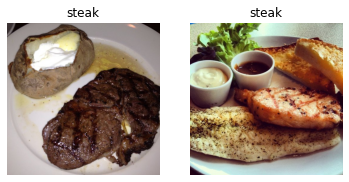

In [ ]:
# Visualize data (requires function 'view_random_image' above)
plt.figure()
plt.subplot(1,2,1)
steak_img = view_random_image('pizza_steak/train/','steak')
plt.subplot(1,2,2)
pizza_img = view_random_image('pizza_steak/train/','steak')

### 2. Preprocess the data (prepare it for a model)
One of the most important steps for a machine learning project is creating a training and test set.

For an image classification project, it's standard to have your data seperated into `train` and `test` directories with subfolders in each for each class.

Our next step is to turn our data into batches

In [ ]:
# Create train and test data generators and rescale the data 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

The ImageDataGenerator class helps us prepare our images into batches as well as perform transformations on them as they get loaded into the model.

In [ ]:
train_dir = "pizza_steak/train"
test_dir = "pizza_steak/test"

In [ ]:
# Turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,target_size=(224,224),class_mode='binary',batch_size=32)
test_data = test_datagen.flow_from_directory(directory=test_dir,target_size=(224,224),class_mode='binary',batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
# get a sample of training data batch
images,labels = train_data.next()
len(images),len(labels)

(32, 32)

Wonderful, it seems our images and labels are in batches of 32. Due to the class_mode parameter being 'binary' our labels are either 0 (pizza) or 1 (steak).

In [ ]:
# View the first batch of labels
labels

array([1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

### 3. Create a model (start with a baseline)

it's good to build a smaller model to acquire a baseline result which you try to improve upon. 🔑 Note: In deep learning a smaller model often refers to a model with less layers than the state of the art (SOTA). For example, a smaller model might have 3-4 layers where as a state of the art model, such as, ResNet50 might have 50+ layers.

In [ ]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [ ]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
# input layer (specify input shape)
model_4 = Sequential([
                      Conv2D(filters=10,kernel_size=3,strides=1,padding='valid',activation='relu',input_shape=(224,224,3)),
                      Conv2D(10,3,activation='relu'),
                      Conv2D(10,3,activation='relu'),
                      Flatten(),
                      Dense(1,activation='sigmoid')    # output layer (specify output shape)
])

A feature can be considered any significant part of an image. For example, in our case, a feature might be the circular shape of pizza. Or the rough edges on the outside of a steak

In [ ]:
# Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer = Adam(),
                metrics = 'accuracy')

Since we're working on a binary classification problem (pizza vs. steak), the loss function we're using is 'binary_crossentropy', if it was mult-iclass, we might use something like 'categorical_crossentropy'.

### 4. Fit a model

steps_per_epoch - this is the number of batches a model will go through per epoch, in our case, we want our model to go through all batches so it's equal to the length of train_data (1500 images in batches of 32 = 1500/32 = ~47 steps)

In [ ]:
# Check lengths of training and test data generators (lengths of bathces)
len(train_data), len(test_data)

(47, 16)

In [ ]:
# Fit the model
history_4 = model_4.fit(train_data, epochs = 5,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=len(test_data))

Epoch 1/2
47/47 [==============================] - 117s 2s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.9134 - val_accuracy: 0.7760
Epoch 2/2
47/47 [==============================] - 118s 3s/step - loss: 5.2040e-04 - accuracy: 1.0000 - val_loss: 0.9603 - val_accuracy: 0.7620


### 5. Evaluate the model

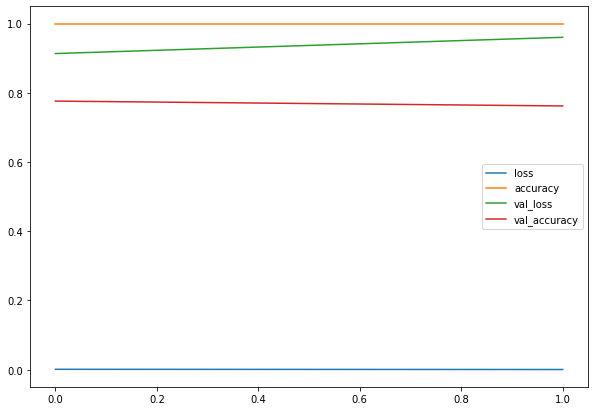

In [ ]:
# Plot the training curves
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10,7))

Hmm, judging by our loss curves, it looks like our model is overfitting the training dataset.

In [ ]:
history_4.history

{'accuracy': [1.0, 1.0],
 'loss': [0.0011115185916423798, 0.0005204040789976716],
 'val_accuracy': [0.7760000228881836, 0.7620000243186951],
 'val_loss': [0.9133995771408081, 0.9603220224380493]}

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

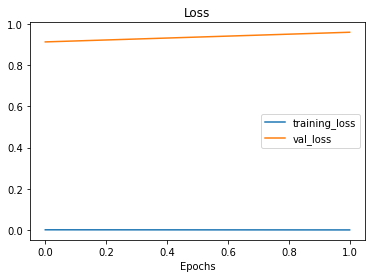

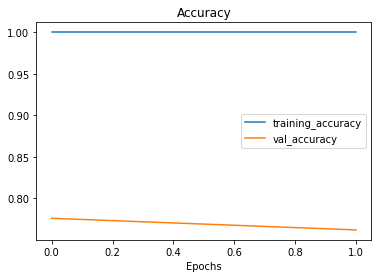

In [ ]:
# Check out the loss curves of model_4
plot_loss_curves(history_4)

If there's a large gap between the training curve and validation curve, it means your model is probably overfitting.

In [ ]:
# Check out our model's architecture
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 218, 218, 10)      910       
_________________________________________________________________
flatten_3 (Flatten)          (None, 475240)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 475241    
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


### 6. Adjust the model parameters

And there are even a few more things we could try to further overfit our model:

1. Increase the number of convolutional layers.
2. Increase the number of convolutional filters.
3. Add another dense layer to the output of our flattened layer.


In [ ]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_5 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

If convolutional layers learn the features of an image you can think of a Max Pooling layer as figuring out the most important of those features

In [ ]:
# Compile model (same as model_4)
model_5.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 53s 1s/step - loss: 0.5976 - accuracy: 0.6973 - val_loss: 0.4782 - val_accuracy: 0.7800
Epoch 2/5
47/47 [==============================] - 52s 1s/step - loss: 0.4662 - accuracy: 0.7920 - val_loss: 0.4714 - val_accuracy: 0.7840
Epoch 3/5
47/47 [==============================] - 51s 1s/step - loss: 0.4317 - accuracy: 0.8227 - val_loss: 0.3743 - val_accuracy: 0.8300
Epoch 4/5
47/47 [==============================] - 51s 1s/step - loss: 0.4173 - accuracy: 0.8113 - val_loss: 0.3693 - val_accuracy: 0.8660
Epoch 5/5
47/47 [==============================] - 52s 1s/step - loss: 0.3911 - accuracy: 0.8440 - val_loss: 0.3331 - val_accuracy: 0.8740


In [ ]:
# Check out the model architecture
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 10)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 109, 109, 10)      910       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 10)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 52, 52, 10)        910       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 26, 26, 10)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6760)             

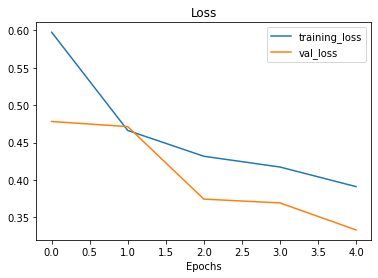

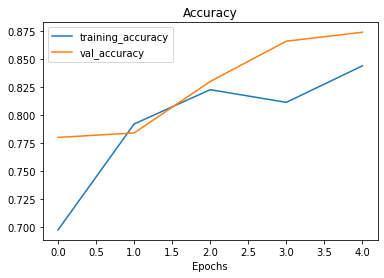

In [ ]:
# Plot loss curves of model_5 results
plot_loss_curves(history_5)

### 7. Data augmentation
 is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar.

🔑 Note: Data augmentation is usally only performed on the training data. Using the ImageDataGenerator built-in data augmentation parameters our images are left as they are in the directories but are randomly manipulated when loaded into the model.

In [ ]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.) 

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,target_size=(224,224),
                                                                   batch_size=32,class_mode='binary', shuffle=False)

# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data_augmented = test_datagen.flow_from_directory(test_dir,target_size=(224,224),
                                                       batch_size=32,class_mode = 'binary')



Augmented training images:
Found 1500 images belonging to 2 classes.
Non-augmented training images:
Found 1500 images belonging to 2 classes.
Unchanged test images:
Found 500 images belonging to 2 classes.


Better than talk about data augmentation, how about we see it?

(remember our motto? visualize, visualize, visualize...)

In [ ]:
# Get data batch samples
images , labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

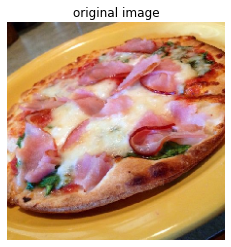

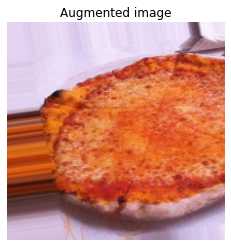

In [ ]:
%matplotlib inline

random_number = random.randint(0, 32)
plt.imshow(images[random_number])
plt.title('original image')
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);


Data augmentation is a way to try and prevent a model overfitting. If your model is overfiting (e.g. the validation loss keeps increasing), you may want to try using data augmentation.

In [ ]:
# Create the model (same as model_5)
model_6 = Sequential([
                      Conv2D(10,3,activation='relu',input_shape=(224,224,3)),
                      MaxPool2D(pool_size=2), #reduce number of features by half
                      Conv2D(10,3,activation='relu'),
                      MaxPool2D(), #default poolsize =2
                      Conv2D(10,3,activation='relu'),
                      MaxPool2D(),
                      Flatten(),
                      Dense(1,activation='sigmoid')
])

#compile a model
model_6.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics = 'accuracy')
# Fit the model
history_6 = model_6.fit(train_data_augmented,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data, 
                        validation_steps=len(test_data),
                        epochs=5)

Epoch 1/5
47/47 [==============================] - 69s 1s/step - loss: 0.7274 - accuracy: 0.4187 - val_loss: 0.6870 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 67s 1s/step - loss: 0.7018 - accuracy: 0.4273 - val_loss: 0.6930 - val_accuracy: 0.5220
Epoch 3/5
47/47 [==============================] - 67s 1s/step - loss: 0.6936 - accuracy: 0.4360 - val_loss: 0.6930 - val_accuracy: 0.5440
Epoch 4/5
47/47 [==============================] - 67s 1s/step - loss: 0.6934 - accuracy: 0.4960 - val_loss: 0.6929 - val_accuracy: 0.5720
Epoch 5/5
47/47 [==============================] - 67s 1s/step - loss: 0.6929 - accuracy: 0.5047 - val_loss: 0.6913 - val_accuracy: 0.6120


🤔 Question: Why didn't our model get very good results on the training set to begin with? 

It's because when we created train_data_augmented we turned off data shuffling using shuffle=False which means our model only sees a batch of a single kind of images at a time.

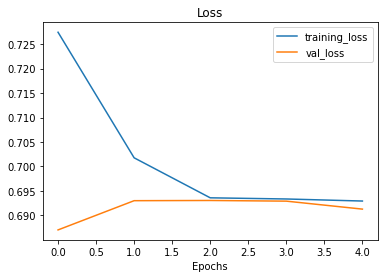

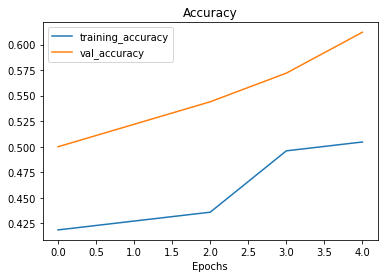

In [ ]:
# Check model's performance history training on augmented data
plot_loss_curves(history_6)

Let's see what happens when we shuffle the augmented training data.

In [ ]:
# Import data and augment it from directories
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode='binary',
                                                                            shuffle=True) # Shuffle data (default)

Found 1500 images belonging to 2 classes.


In [ ]:
# Create the model (same as model_5 and model_6)
model_7 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_7 = model_7.fit(train_data_augmented_shuffled, # now the augmented data is shuffled
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 67s 1s/step - loss: 0.6893 - accuracy: 0.5613 - val_loss: 0.6185 - val_accuracy: 0.6600
Epoch 2/5
47/47 [==============================] - 66s 1s/step - loss: 0.5918 - accuracy: 0.6713 - val_loss: 0.4613 - val_accuracy: 0.8040
Epoch 3/5
47/47 [==============================] - 66s 1s/step - loss: 0.5151 - accuracy: 0.7500 - val_loss: 0.4255 - val_accuracy: 0.8040
Epoch 4/5
47/47 [==============================] - 66s 1s/step - loss: 0.4848 - accuracy: 0.7700 - val_loss: 0.3573 - val_accuracy: 0.8460
Epoch 5/5
47/47 [==============================] - 67s 1s/step - loss: 0.4752 - accuracy: 0.7727 - val_loss: 0.3597 - val_accuracy: 0.8540


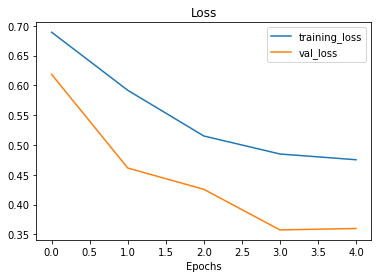

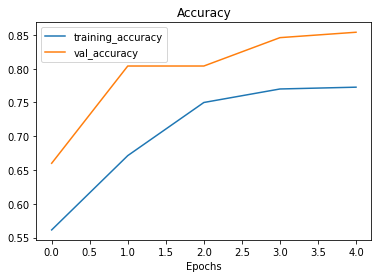

In [ ]:
# Check model's performance history training on augmented data
plot_loss_curves(history_7)

### 8. Repeat until satisified

Since we've already beaten our baseline, there are a few things we could try to continue to improve our model:
1. Increase the number of model layers
2. Increase the number of filters.
3. Train for longer (more epochs).
4. Finding an ideal learning rate.
4. Get more data (give the model more opportunities to learn).
5. Use transfer learning to leverage what another image model has learned and adjust it for our own use case.



In [ ]:
# Create a CNN model (same as Tiny VGG but for binary classification - https://poloclub.github.io/cnn-explainer/ )
model_8 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)), # same input shape as our images
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_8.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_8 = model_8.fit(train_data_augmented_shuffled,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 119s 3s/step - loss: 0.6640 - accuracy: 0.6133 - val_loss: 0.4862 - val_accuracy: 0.8260
Epoch 2/5
47/47 [==============================] - 119s 3s/step - loss: 0.5492 - accuracy: 0.7327 - val_loss: 0.4471 - val_accuracy: 0.8180
Epoch 3/5
47/47 [==============================] - 118s 3s/step - loss: 0.5190 - accuracy: 0.7653 - val_loss: 0.4237 - val_accuracy: 0.8340
Epoch 4/5
47/47 [==============================] - 118s 3s/step - loss: 0.5115 - accuracy: 0.7573 - val_loss: 0.4059 - val_accuracy: 0.8340
Epoch 5/5
47/47 [==============================] - 118s 3s/step - loss: 0.4957 - accuracy: 0.7640 - val_loss: 0.3894 - val_accuracy: 0.8420


In [ ]:
# Check model_1 architecture (same as model_8)
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28090)             0

In [ ]:
# Check model_8 architecture (same as model_1)
model_8.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 53, 53, 10)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 28090)            

Now let's check out our TinyVGG model's performance.

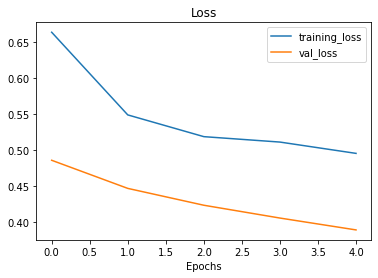

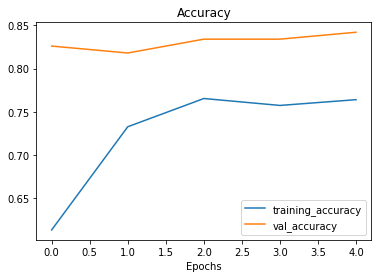

In [ ]:
# Check out the TinyVGG model performance
plot_loss_curves(history_8)

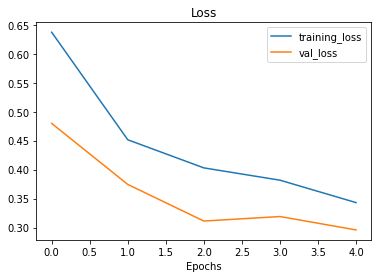

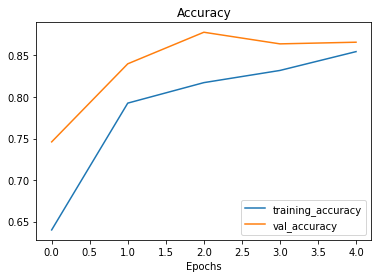

In [ ]:
# How does this training curve look compared to the one above?
plot_loss_curves(history_1)

## Making a prediction with our trained model

To really test it out, we'll upload a couple of our own images and see how the model goes.

First, let's remind ourselves of the classnames and view the image we're going to test on.

In [ ]:
# Classes we're working with
print(class_names)

['.DS_Store' 'pizza' 'steak']


The first test image we're going to use is [a delicious steak](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg) I cooked the other day.

--2021-10-03 15:35:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg.3’

03-steak.jpeg.3     100%[===================>]   1.89M  --.-KB/s    in 0.07s   

2021-10-03 15:35:23 (27.2 MB/s) - ‘03-steak.jpeg.3’ saved [1978213/1978213]



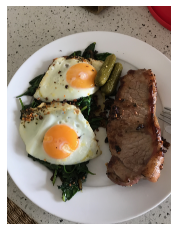

In [ ]:
# View our example image
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg 
steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False);

In [ ]:
# Check the shape of our image
steak.shape

(4032, 3024, 3)

Since our model takes in images of shapes `(224, 224, 3)`, we've got to reshape our custom image to use it with our model.

To do so, we can import and decode our image using [`tf.io.read_file`](https://www.tensorflow.org/api_docs/python/tf/io/read_file) (for readining files) and [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image) (for resizing our image and turning it into a tensor).

In [ ]:
# create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename,img_shape=224):
  
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  img = tf.image.decode_image(img,channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img,size=[img_shape,img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.

  return img

Now we've got a function to load our custom image, let's load it in.

In [ ]:
# Load in and preprocess our custom image
steak = load_and_prep_image("03-steak.jpeg")
steak

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.6377451 , 0.6220588 , 0.57892156],
        [0.6504902 , 0.63186276, 0.5897059 ],
        [0.63186276, 0.60833335, 0.5612745 ],
        ...,
        [0.52156866, 0.05098039, 0.09019608],
        [0.49509802, 0.04215686, 0.07058824],
        [0.52843136, 0.07745098, 0.10490196]],

       [[0.6617647 , 0.6460784 , 0.6107843 ],
        [0.6387255 , 0.6230392 , 0.57598037],
        [0.65588236, 0.63235295, 0.5852941 ],
        ...,
        [0.5352941 , 0.06862745, 0.09215686],
        [0.529902  , 0.05931373, 0.09460784],
        [0.5142157 , 0.05539216, 0.08676471]],

       [[0.6519608 , 0.6362745 , 0.5892157 ],
        [0.6392157 , 0.6137255 , 0.56764704],
        [0.65637255, 0.6269608 , 0.5828431 ],
        ...,
        [0.53137255, 0.06470589, 0.08039216],
        [0.527451  , 0.06862745, 0.1       ],
        [0.52254903, 0.05196078, 0.0872549 ]],

       ...,

       [[0.49313724, 0.42745098, 0.31029412],
        [0.05

Wonderful, our image is in tensor format, time to try it with our model!

Well, the batch size becomes the first dimension. So in reality, our model was trained on data in the shape of (batch_size, 224, 224, 3).

We can fix this by adding an extra to our custom image tensor using tf.expand_dims.

In [ ]:
# Add an extra axis
print(f"Shape before new dimension: {steak.shape}")
steak = tf.expand_dims(steak, axis=0) # add an extra dimension at axis 0
#steak = steak[tf.newaxis, ...] # alternative to the above, '...' is short for 'every other dimension'
print(f"Shape after new dimension: {steak.shape}")
steak.shape

Shape before new dimension: (224, 224, 3)
Shape after new dimension: (1, 224, 224, 3)


TensorShape([1, 224, 224, 3])

Our custom image has a batch size of 1! Let's make a prediction on it.

In [ ]:
# Make a prediction on custom image tensor
pred = model_8.predict(steak)
pred

array([[0.7375326]], dtype=float32)

Since we're working with a binary classification problem, if the prediction probability is over 0.5, according to the model, the prediction is most likely to be the postive class (class 1).

🔑 Note: The 0.5 cutoff can be adjusted to your liking. For example, you could set the limit to be 0.8 and over for the positive class and 0.2 for the negative class. However, doing this will almost always change your model's performance metrics so be sure to make sure they change in the right direction.

In [ ]:
class_names

array(['.DS_Store', 'pizza', 'steak'], dtype='<U9')

In [ ]:
# Remind ourselves of our class names
class_names_2 = class_names[1:]

In [ ]:
# We can index the predicted class by rounding the prediction probability
pred_class = class_names_2[int(tf.round(pred)[0][0])]
pred_class

'steak'

In [ ]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names_2[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

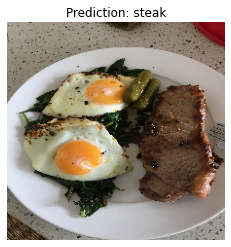

In [ ]:
# Test our model on a custom image
pred_and_plot(model_8, "03-steak.jpeg", class_names)

Nice! Our model got the prediction right.

The only downside of working with food is this is making me hungry.

Let's try one more image.

--2021-10-03 15:42:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg.1’

03-pizza-dad.jpeg.1 100%[===================>]   2.74M  --.-KB/s    in 0.1s    

2021-10-03 15:42:21 (22.6 MB/s) - ‘03-pizza-dad.jpeg.1’ saved [2874848/2874848]



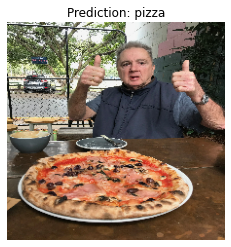

In [ ]:
# Download another test image and make a prediction on it
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg 
pred_and_plot(model_8, "03-pizza-dad.jpeg", class_names_2)

--2021-10-03 15:46:25--  https://imagevars.gulfnews.com/2021/01/25/Slider-Station-Burger_177385da28e_original-ratio.jpg
Resolving imagevars.gulfnews.com (imagevars.gulfnews.com)... 13.225.103.98, 13.225.103.126, 13.225.103.65, ...
Connecting to imagevars.gulfnews.com (imagevars.gulfnews.com)|13.225.103.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62669 (61K) [image/jpg]
Saving to: ‘Slider-Station-Burger_177385da28e_original-ratio.jpg’

Slider-Station-Burg 100%[===================>]  61.20K   168KB/s    in 0.4s    

2021-10-03 15:46:26 (168 KB/s) - ‘Slider-Station-Burger_177385da28e_original-ratio.jpg’ saved [62669/62669]



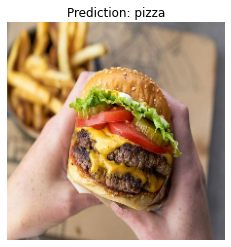

In [ ]:
!wget https://imagevars.gulfnews.com/2021/01/25/Slider-Station-Burger_177385da28e_original-ratio.jpg
pred_and_plot(model_8, "Slider-Station-Burger_177385da28e_original-ratio.jpg", class_names_2)

# Multi-class Classification
now we're going to step things up a notch with 10 classes of food (multi-class classification)

1. Become one with the data
2. Preprocess the data (get it ready for a model)
3. Create a model (start with a baseline)
4. Fit the model (overfit it to make sure it works)
5. Evaluate the model
6. Adjust differet hyperparameters and improve the model (try to beat baseline/reduce overfitting)
7. Repeat until satisfied

## 1. Import and become one with the data

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# Unzip our data
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-10-08 10:34:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.219.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.219.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   190MB/s    in 2.6s    

2021-10-08 10:34:16 (190 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
import os
# Walk through 10 classes of food image data

for dirpath, dirnames, filenames, in os.walk('10_food_classes_all_data'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}".')


There are 2 directories and 0 images in "10_food_classes_all_data".
There are 10 directories and 0 images in "10_food_classes_all_data/train".
There are 0 directories and 750 images in "10_food_classes_all_data/train/grilled_salmon".
There are 0 directories and 750 images in "10_food_classes_all_data/train/steak".
There are 0 directories and 750 images in "10_food_classes_all_data/train/ramen".
There are 0 directories and 750 images in "10_food_classes_all_data/train/fried_rice".
There are 0 directories and 750 images in "10_food_classes_all_data/train/pizza".
There are 0 directories and 750 images in "10_food_classes_all_data/train/hamburger".
There are 0 directories and 750 images in "10_food_classes_all_data/train/chicken_curry".
There are 0 directories and 750 images in "10_food_classes_all_data/train/sushi".
There are 0 directories and 750 images in "10_food_classes_all_data/train/ice_cream".
There are 0 directories and 750 images in "10_food_classes_all_data/train/chicken_wings".

In [ ]:
# Setup the train and test directories
train_dir = '/content/10_food_classes_all_data/train/'
test_dir = '/content/10_food_classes_all_data/test/'

In [ ]:
#let's get the class names
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))

In [ ]:
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

image shape :(512, 512, 3)


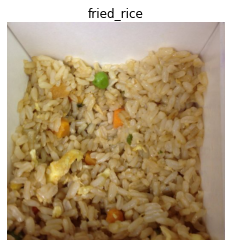

In [ ]:
# Visualize, visualize, visualize
import random 
img = view_random_image(target_dir = train_dir, target_class=random.choice(class_names))

In [ ]:
random.choice(class_names)

'chicken_curry'

## 2. Preprocess the data (prepare it for a model)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,target_size=(224,224),batch_size=32,class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir,target_size=(224,224),batch_size=32,class_mode='categorical')


Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## 3. Create a model (start with a baseline)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation

# Create our model (very similar to previous models but actually the same as CNN explainer website)
model_8 = Sequential([
                      Conv2D(10,3,input_shape=(224,224,3)),
                      Activation(activation='relu'),
                      Conv2D(10,3,activation='relu'),
                      MaxPool2D(2),
                      Conv2D(10,3,activation='relu'),
                      Conv2D(10,3,activation='relu'),
                      MaxPool2D(2),
                      Flatten(),
                      Dense(10,activation='softmax') # changed to have 10 output neurons and use the softmax activation function

])

#compile the model
model_8.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics =['accuracy']) 

## 4. Fit a model

In [ ]:
history_8  =model_8.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 58s 233ms/step - loss: 2.2702 - accuracy: 0.1352 - val_loss: 2.1303 - val_accuracy: 0.2236
Epoch 2/5
235/235 [==============================] - 53s 228ms/step - loss: 1.9857 - accuracy: 0.3036 - val_loss: 1.8697 - val_accuracy: 0.3588
Epoch 3/5
235/235 [==============================] - 54s 231ms/step - loss: 1.7611 - accuracy: 0.4060 - val_loss: 1.8521 - val_accuracy: 0.3664
Epoch 4/5
235/235 [==============================] - 54s 228ms/step - loss: 1.4598 - accuracy: 0.5187 - val_loss: 1.8856 - val_accuracy: 0.3560
Epoch 5/5
235/235 [==============================] - 54s 231ms/step - loss: 0.9417 - accuracy: 0.6948 - val_loss: 2.1843 - val_accuracy: 0.3448


## 5. Evaulate the model

In [ ]:
# Evalaute on the test data
model_8.evaluate(test_data)

In [ ]:
# Check out the model's loss curves on the 10 classes
plot_loss_curves(history_8)

What do these loss curves tell us?

Well... it seems our model is overfitting the training set quite badly... in other words, it's getting great results on the training daa but fails to generalize well to unseen data and performs poorly on the test dataset.

## 6. Adjust the model hyperparameters (to beat the baseline/reduce overfitting)

So, let's try and fix overfitting by...
1. Get more data
2. Simpliy the model
3. Use data augmentation
4. Use transfer learning

In [ ]:
# How about we try and simplify the model first?
# Let's try to remove 2 convolutional layers...
model_9 = Sequential([
  Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation="softmax")
])

model_9.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model with 2x conv layers removed
history_9 = model_9.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 51s 214ms/step - loss: 2.1543 - accuracy: 0.2183 - val_loss: 2.0056 - val_accuracy: 0.2776
Epoch 2/5
235/235 [==============================] - 50s 212ms/step - loss: 1.8537 - accuracy: 0.3553 - val_loss: 1.9216 - val_accuracy: 0.3164
Epoch 3/5
235/235 [==============================] - 49s 210ms/step - loss: 1.5443 - accuracy: 0.4841 - val_loss: 1.9775 - val_accuracy: 0.3364
Epoch 4/5
235/235 [==============================] - 49s 210ms/step - loss: 1.0678 - accuracy: 0.6664 - val_loss: 2.3349 - val_accuracy: 0.3068
Epoch 5/5
235/235 [==============================] - 49s 210ms/step - loss: 0.6132 - accuracy: 0.8149 - val_loss: 2.5880 - val_accuracy: 0.2960


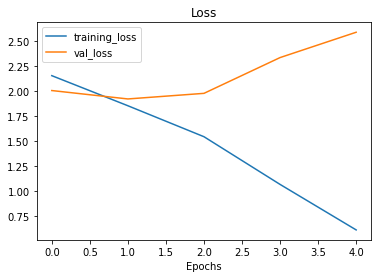

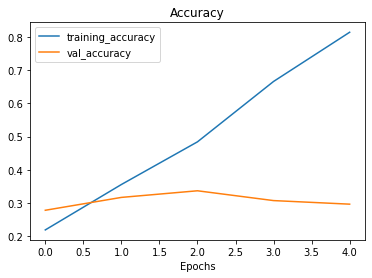

In [ ]:
# Check out the loss curves of model_9
plot_loss_curves(history_9)

In [ ]:
model_9.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 10)      0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 109, 109, 10)      910       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 29160)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                291610    
Total params: 292,800
Trainable params: 292,800
Non-trainable params: 0
________________________________________________

In [ ]:
model_8.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 222, 222, 10)      280       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 10)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0

Looks like our "simplifying the model" experiment didn't work... the accuracy went down and overfitting continued...

How about we try data augmentation??

## Trying to reduce overfitting with data augmentation

Let's try and improve our model's results by using augmented training data...

In [ ]:
# Create an augmented data generator instance
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode="categorical")

Found 7500 images belonging to 10 classes.


In [ ]:
# Let's create another model but this time we'll fit it on the augmented training data of 10 classes
model_10 = tf.keras.models.clone_model(model_8)

# Compile the cloned model (using the same setup as previous models)
model_10.compile(loss="categorical_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

In [ ]:
history_10 = model_10.fit(train_data_augmented,
                          epochs=5,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 127s 538ms/step - loss: 2.2273 - accuracy: 0.1653 - val_loss: 2.0565 - val_accuracy: 0.2536
Epoch 2/5
235/235 [==============================] - 128s 544ms/step - loss: 2.1033 - accuracy: 0.2385 - val_loss: 1.9562 - val_accuracy: 0.3132
Epoch 3/5
235/235 [==============================] - 128s 546ms/step - loss: 2.0199 - accuracy: 0.2840 - val_loss: 1.8810 - val_accuracy: 0.3492
Epoch 4/5
235/235 [==============================] - 125s 534ms/step - loss: 1.9608 - accuracy: 0.3155 - val_loss: 1.8276 - val_accuracy: 0.3576
Epoch 5/5
235/235 [==============================] - 125s 533ms/step - loss: 1.9193 - accuracy: 0.3340 - val_loss: 1.7746 - val_accuracy: 0.3912


In [ ]:
# Baseline results
model_8.evaluate(test_data)

79/79 [==============================] - 12s 157ms/step - loss: 2.1843 - accuracy: 0.3448


[2.184349298477173, 0.3447999954223633]

In [ ]:
# Same model as baseline but with data augmentation turned on results
model_10.evaluate(test_data)

79/79 [==============================] - 12s 155ms/step - loss: 1.7746 - accuracy: 0.3912


[1.7746351957321167, 0.3912000060081482]

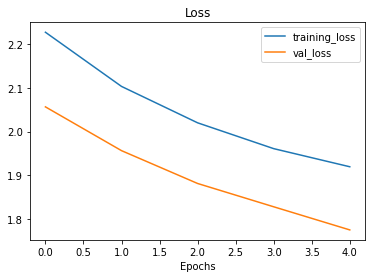

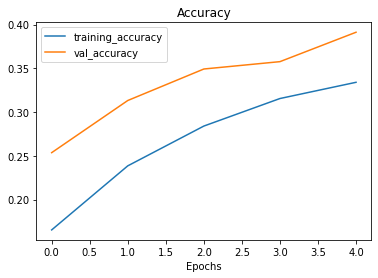

In [ ]:
# Check out our model trained on augmented data's loss curves
plot_loss_curves(history_10)

Woah! That looks much better, the loss curves are much closer to each other than the baseline model and they look like they're heading in the right direction (certainly not the wrong direction) so if we were to train for longer, we might see further improvements.

1. restructuring our model's architecture (increasing layers/hidden units)
2. adjust the learning rate
3. try different methods of data augmentation (adjust the hyperparameters in our ImageDataGenerator instance)
4. training for longer (e.g. 10 epochs instead of 5 epochs)
5. try transfer learning

## Making a prediction with our trained model¶

Let's use our trained model to make some predictions on our own custom images!

In [ ]:
# Remind ourselves of the classes our model is trained on
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [ ]:
# Download some custom images
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg

--2021-10-08 11:04:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg’

03-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.06s   

2021-10-08 11:04:06 (43.2 MB/s) - ‘03-pizza-dad.jpeg’ saved [2874848/2874848]

--2021-10-08 11:04:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting

In [ ]:
list(class_names)

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# Reconfig pred_and_plot function to work with multi-class images
def pred_and_plot(model, filename, class_names=class_names):
  """
  Imports an image located at filename, makes a prediction with model
  and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Add in logic for multi-class & get pred_class name
  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred[0]))]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

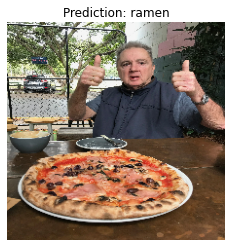

In [ ]:
pred_and_plot(model_10,filename='03-pizza-dad.jpeg',class_names=class_names)

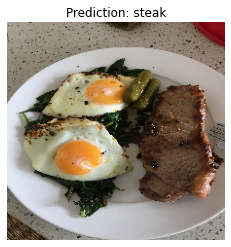

In [ ]:
pred_and_plot(model=model_10,
              filename="03-steak.jpeg",
              class_names=class_names)

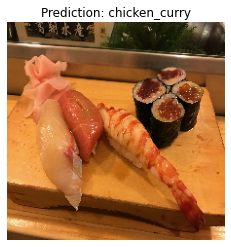

In [ ]:
pred_and_plot(model=model_10,
              filename="03-sushi.jpeg",
              class_names=class_names)

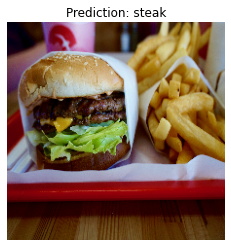

In [ ]:
pred_and_plot(model=model_10,
              filename="03-hamburger.jpeg",
              class_names=class_names)

Looks like our model didn't perform very well on our custom images but this because it only achieved ~39% accuracy on the test data. So we can expect it to function quite poorly on other unseen data.

## Saving and loading our model

In [ ]:
# Save a model
model_10.save("saved_trained_model_10")

INFO:tensorflow:Assets written to: saved_trained_model_10/assets


In [ ]:
# Load in a trained model and evaluate it
loaded_model_10 = tf.keras.models.load_model("saved_trained_model_10")
loaded_model_10.evaluate(test_data)

79/79 [==============================] - 12s 155ms/step - loss: 1.7746 - accuracy: 0.3912


[1.7746351957321167, 0.3912000060081482]

In [ ]:
# Compare our loaded model to our existing model
model_10.evaluate(test_data)

79/79 [==============================] - 12s 156ms/step - loss: 1.7746 - accuracy: 0.3912


[1.7746357917785645, 0.3912000060081482]